In [69]:
### Converting shape files with vectors into raster file with distance to vector
# Points within vector / on border are value 0
# Resolution of 30 m


# Load vector shape file
import geopandas as gpd
import rasterio
from rasterio.mask import mask

from rasterio.features import rasterize
from rasterio.transform import from_origin
from shapely.geometry import box
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

# Load the shapefile
gdf = gpd.read_file("capas/antropico/Areas_Pobladas/Areas_Pobladas.shp")
gdf = gdf.to_crs(epsg=32719) ### IMPORTANT: CRS FOR CHILE
region_bounds = gdf.total_bounds  # Or use your predefined region bounds
minx, miny, maxx, maxy = region_bounds

/Users/abbystokes/anaconda3/envs/geoai/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/Users/abbystokes/anaconda3/envs/geoai/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 421 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(


In [127]:
# Define region of interest
# Araucania, BioBio, Coquimbo, Ohiggins, Maule, Metropolitana, Valparaiso, Nuble
regions = gpd.read_file("Regiones/Regional.shp")
regions = regions.to_crs(epsg=32719)  ### IMPORTANT: CRS FOR CHILE

output_path = 'capas/antropico/Areas_Pobladas/distance_to_populated_RM.tif'

#regions = regions.to_crs("EPSG:4326") 
#included_regions = ['Región de Coquimbo','Región de Valparaíso','Región Metropolitana de Santiago','Región de La Araucanía','Región del Bío-Bío','Región de Ñuble','Región del Maule']
included_regions = ['Región Metropolitana de Santiago']

regions = regions[regions['Region'].isin(included_regions)] 

minx, miny, maxx, maxy = regions.total_bounds

In [128]:
# Resolution to 30 m
minx, miny, maxx, maxy = regions.total_bounds
resolution = 30  # 30 meters per pixel

width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)
transform = from_origin(minx, maxy, resolution, resolution)



In [129]:
regions.total_bounds

array([ 249135.32402329, 6205240.20871755,  428386.91148214,
       6355826.61783707])

In [130]:
# For valparaiso only - to exclude the islands

#from shapely.geometry import box
#bbox = box(0,  6195203.63903423,   407513.86185809,
#        7044568.05015099)  # left, bottom, right, top

# Intersect region with bounding box to remove islands
#regions = regions[regions.intersects(bbox)]
#regions = regions.intersection(bbox)
#regions = gpd.GeoDataFrame(geometry=regions, crs=regions.crs)
#regions.plot()

In [131]:
# Rasterize populated areas
populated_raster = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

In [132]:
populated_raster.shape

(5019, 5975)

In [133]:
# Distance transform --- note this is O(n^2), kernel will crash if populated raster is too large
distance = distance_transform_edt(populated_raster == 0) * resolution


In [134]:
gdf.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [135]:

# Save to a new raster
out_meta = {
    'driver': 'GTiff',
    'height': height,
    'width': width,
    'count': 1,
    'dtype': 'float32',
    'crs': gdf.crs,
    'transform': transform
}

with rasterio.open(output_path, "w", **out_meta) as dst:
    dst.write(distance.astype(np.float32), 1)

In [136]:

# Crop to region
# Reproject region to match raster CRS
with rasterio.open(output_path) as src:
    raster_crs = src.crs
    regions = regions.to_crs(raster_crs)

    # Mask the raster using the region polygon
    out_image, out_transform = mask(src, regions.geometry, crop=True, nodata=np.nan)

    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": np.nan
    })

# Save the masked raster
with rasterio.open(output_path, "w", **out_meta) as dst:
    dst.write(out_image)

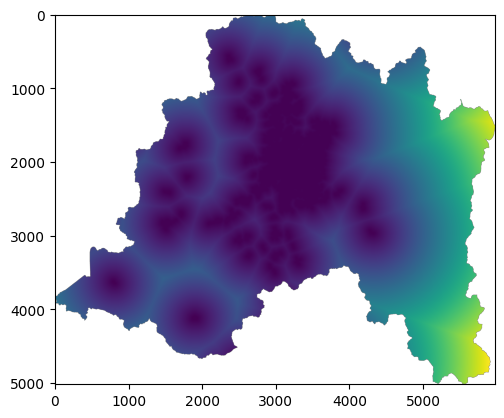

In [137]:

raster = rasterio.open(output_path)
plt.imshow(raster.read(1))